## Libraries

In [1]:
import pandas as pd
import numpy as np
from crepes import ConformalClassifier, ConformalPredictiveSystem
from crepes.extras import hinge, margin, binning, DifficultyEstimator

## Data

### Calibration 

In [24]:
# xxx = df_cal[df_cal['gt_obj_id']==df_cal['pred_obj_id']]
# unique_counts = xxx['gt_obj_id'].value_counts()
# print(unique_counts)

In [2]:
data_dir = "old_dataset.xlsx" #directory
df_cal=pd.read_excel(data_dir,sheet_name='valid_3') #cal dataset with conf=0.25
# df_cal_tp = df_cal[df_cal['TP']==1] # True Positive Predictions Only
df_cal_tp = df_cal[df_cal['gt_obj_id'] == df_cal['pred_obj_id']]

# 43 samples from each class
sample_size = 100

# Set a seed for the random number generator
seed = 100

df_sampled = df_cal_tp.groupby('pred_obj_id').apply(lambda x: x.sample(sample_size, replace=True, random_state=seed))
df_sampled = df_sampled.reset_index(drop=True)

df_test=pd.read_excel(data_dir,sheet_name='test_3') #test dataset with conf=0.25
df_test_filtered = df_test[df_test['pred_obj_id'] != '-']
df_calibration=df_sampled
df_testing=df_test_filtered

In [3]:
unique_counts = df_calibration['gt_obj_id'].value_counts()
print(unique_counts)

0    100
1    100
2    100
3    100
Name: gt_obj_id, dtype: int64


In [4]:
df_subset= df_cal_tp[['gt_obj_id',
        'pred_obj_id', 
        'objectness_score',
        'ascaris_conf_score',
        'trichuris_conf_score',
        'hookworm_conf_score',
        'schistosoma_conf_score']]

C:\Users\M\AppData\Local\Temp\ipykernel_21108\1309698823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1))


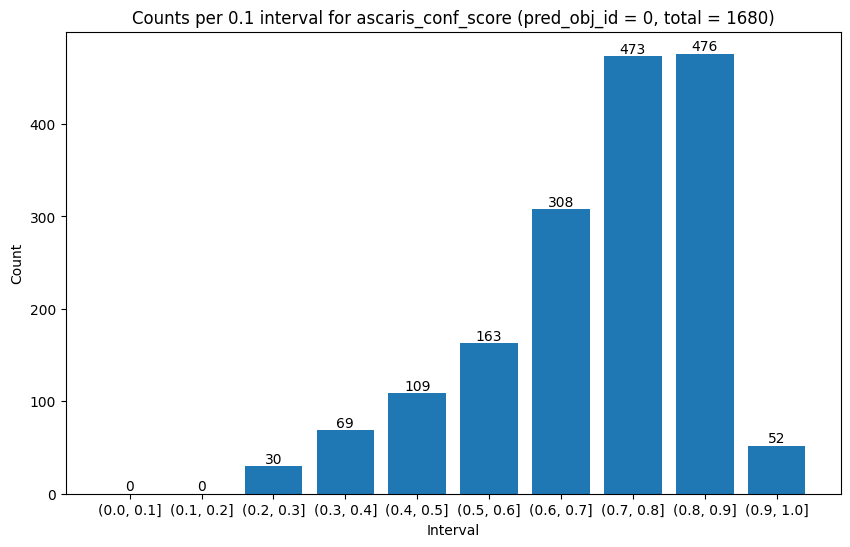

C:\Users\M\AppData\Local\Temp\ipykernel_21108\1309698823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1))


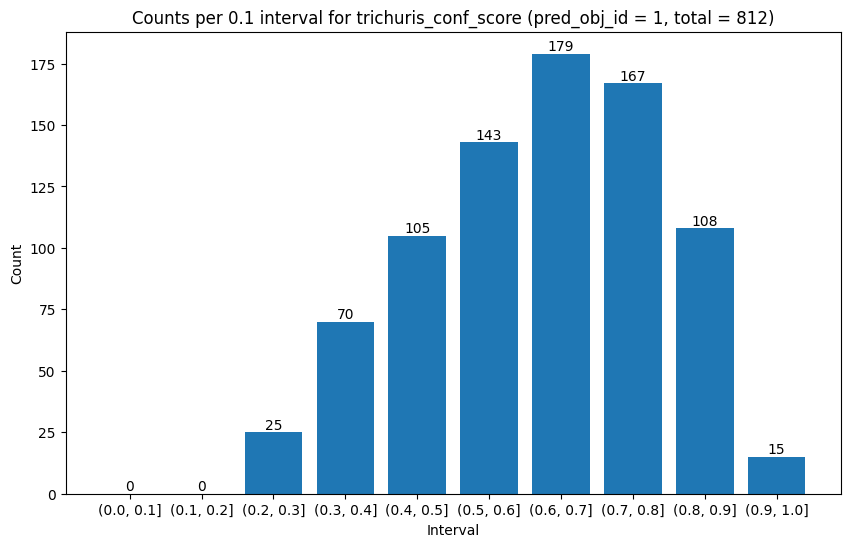

C:\Users\M\AppData\Local\Temp\ipykernel_21108\1309698823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1))


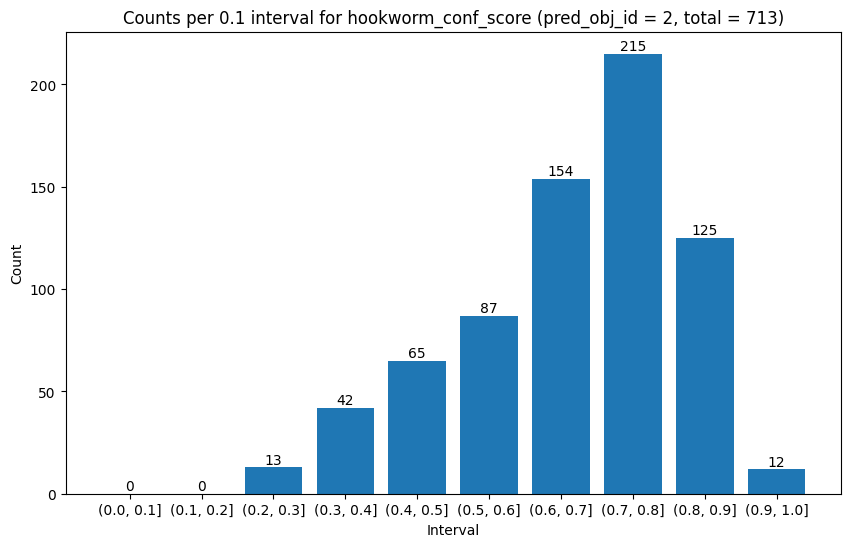

C:\Users\M\AppData\Local\Temp\ipykernel_21108\1309698823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1))


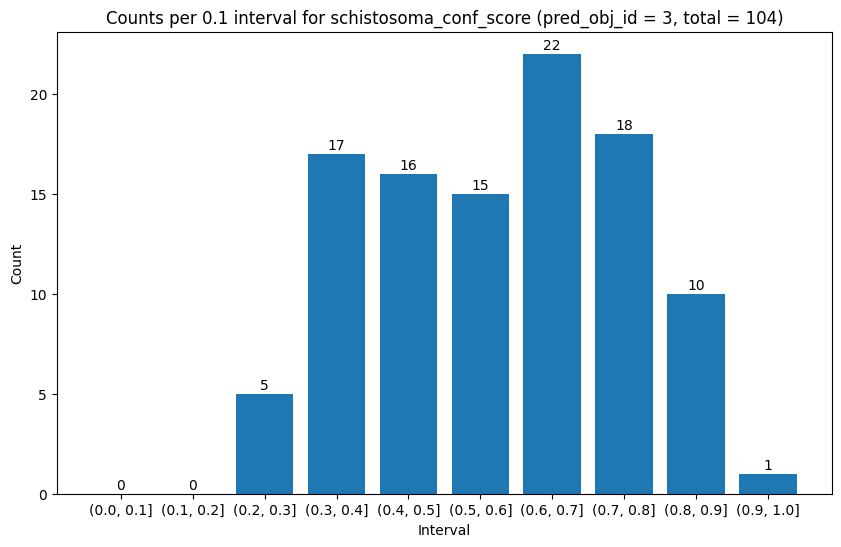

In [5]:
import matplotlib.pyplot as plt

# Define the mapping between 'pred_obj_id' and the corresponding confidence score column
mapping = {0: 'ascaris_conf_score', 1: 'trichuris_conf_score', 2: 'hookworm_conf_score', 3: 'schistosoma_conf_score'}

# Loop over the mapping
for pred_obj_id, conf_score_column in mapping.items():
    # Filter the DataFrame by 'pred_obj_id'
    df_cal_tp = df_subset[df_subset['pred_obj_id'] == pred_obj_id]
    
    # Categorize the data into 0.1 intervals
    df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1))
    
    # Count the number of occurrences in each interval
    counts = df_cal_tp[conf_score_column].value_counts().sort_index()
    
    # Calculate the total count
    total_count = counts.sum()
    
    # Create a bar plot of the counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel('Interval')
    plt.ylabel('Count')
    plt.title(f'Counts per 0.1 interval for {conf_score_column} (pred_obj_id = {pred_obj_id}, total = {total_count})')
    
    # Add the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
    plt.show()

In [6]:
from my_functions import (softmax, 
                          softmax_df, 
                          calculate_logit, 
                          calculate_sigmoid, 
                          calculate_softmax,
                          calculate_hinge_scores,
                          calculate_p_values,
                          calculate_prediction_sets)

In [ ]:
# def calculate_sigmoid(df, conf_score_cols, objectness_score_col, sigmoid_cols):
#     """
#     Calculate sigmoid values by dividing conf_score by objectness_score.
#     """
#     df[sigmoid_cols] = df[conf_score_cols] / df[objectness_score_col].values[:, None]
#     return df

In [61]:
# conf_score_columns = [
#     'ascaris_conf_score',
#     'trichuris_conf_score',
#     'hookworm_conf_score',
#     'schistosoma_conf_score']
# objectness_score_col = 'objectness_score'
# sigmoid_cols = [
#     'ascaris_sigmoid',
#     'trichuris_sigmoid',
#     'hookworm_sigmoid',
#     'schistosoma_sigmoid']

# df_calibration = calculate_sigmoid(
#     df_calibration, 
#     conf_score_columns, 
#     objectness_score_col, 
#     sigmoid_cols
# )
# # softmax_columns = [
# #     'ascaris_softmax', 
# #     'trichuris_softmax', 
# #     'hookworm_softmax', 
# #     'schistosoma_softmax']
# # df_calibration = softmax(
# #     df_calibration)

## Calibration stage

In [7]:
alphas_cal = hinge(
    df_calibration[[
        'ascaris_conf_score',
        'trichuris_conf_score',
        'hookworm_conf_score',
        'schistosoma_conf_score']].values,
    [0,1,2,3],df_calibration[['pred_obj_id']].values
)
cc_std = ConformalClassifier()
cc_std.fit(alphas_cal)
display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

In [63]:
# alphas_cal = hinge(
#     df_calibration[[
#         'ascaris_sigmoid',
#         'trichuris_sigmoid',
#         'hookworm_sigmoid',
#         'schistosoma_sigmoid']].values,
#     [0,1,2,3],df_calibration[['pred_obj_id']].values
# )
# cc_std = ConformalClassifier()
# cc_std.fit(alphas_cal)
# display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

## Testing stage

### Applying the hinge on the testing dataset

In [28]:
conf_score_columns = [
    'ascaris_conf_score',
    'trichuris_conf_score',
    'hookworm_conf_score',
    'schistosoma_conf_score']
# objectness_score_col = 'objectness_score'
# sigmoid_cols = [
#     'ascaris_sigmoid',
#     'trichuris_sigmoid',
#     'hookworm_sigmoid',
#     'schistosoma_sigmoid']

# df_testing = calculate_sigmoid(
#     df_testing, 
#     conf_score_columns, 
#     objectness_score_col, 
#     sigmoid_cols
# )

hinge_score_cols = [
    'ascaris_hinge_score', 
    'trichuris_hinge_score', 
    'hookworm_hinge_score', 
    'schistosoma_hinge_score']
df_testing = calculate_hinge_scores(
    df_testing, 
    conf_score_columns, 
    hinge_score_cols)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
conf_score_columns = [
    'ascaris_conf_score',
    'trichuris_conf_score',
    'hookworm_conf_score',
    'schistosoma_conf_score']
hinge_score_cols = [
    'ascaris_hinge_score', 
    'trichuris_hinge_score', 
    'hookworm_hinge_score', 
    'schistosoma_hinge_score']
df_testing = calculate_hinge_scores(
    df_testing, 
    conf_score_columns, 
    hinge_score_cols)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
p_value_cols = [
    'ascaris_p_value', 
    'trichuris_p_value', 
    'hookworm_p_value', 
    'schistosoma_p_value']
df_testing = calculate_p_values(
    df_testing, 
    hinge_score_cols, 
    p_value_cols, 
    cc_std)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [10]:
p_set_cols = [
    'ascaris_p_set', 
    'trichuris_p_set', 
    'hookworm_p_set', 
    'schistosoma_p_set']
df_testing = calculate_prediction_sets(
    df_testing, 
    hinge_score_cols, 
    p_set_cols, 
    cc_std,
    confidence=0.99)

In [11]:
non_confirmity_scores = df_testing[df_testing['gt_obj_id']!='-'][['ascaris_hinge_score', 'trichuris_hinge_score', 'hookworm_hinge_score', 'schistosoma_hinge_score']].values
non_confirmity_scores = non_confirmity_scores.astype(np.float64)
classes = [0,1,2,3]
y_test = df_testing[df_testing['gt_obj_id']!= '-']['gt_obj_id'].values
y_test = y_test.astype(np.int64)
cc_std.evaluate(non_confirmity_scores,classes, y_test, metrics=['error','avg_c','one_c','empty'])

{'error': 0.024893746205221667,
 'avg_c': 0.9805707346690953,
 'one_c': 0.9805707346690953,
 'empty': 0.019429265330904676}

### 1. Singleton TPs

In [12]:
# Filter out '-' class
df_testing_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_testing_filtered['gt_obj_id'].value_counts()
pred_counts = df_testing_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_testing[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id matches pred_obj_id
mask_singleton_tp = (one_counts == 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_tp = df_testing[mask_singleton_tp]
singleton_counts = df_singleton_tp['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1
mask_non_singleton = (one_counts > 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_non_singleton_tp = df_testing[mask_non_singleton]
non_singleton_counts = df_non_singleton_tp['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_empty_set_tp = df_testing[mask_empty_set]
empty_set_counts = df_empty_set_tp['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_df = singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton Counts'})
non_singleton_counts_df = non_singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton Counts'})
empty_set_counts_df = empty_set_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton Counts,Non-Singleton Counts,Empty Set Counts
0,ascaris,854,860,848,NaN,4.0
1,hookworm,375,376,374,1.0,NaN
2,trichuris,366,359,356,NaN,2.0
3,schistosoma,52,52,52,NaN,NaN


In [31]:
df_non_singleton_tp[[
    'gt_obj_id', 
    'pred_obj_id', 
    'ascaris_p_set', 
    'trichuris_p_set', 
    'hookworm_p_set', 
    'schistosoma_p_set', 
    'ascaris_conf_score', 
    'trichuris_conf_score', 
    'hookworm_conf_score', 
    'schistosoma_conf_score'
]]
df_non_singleton_tp.iloc[0]

filename                   test_150.jpeg
image_width                         1640
image_height                        1232
gt_obj_id                              2
gt_x_center                       0.9073
gt_y_center                       0.0272
gt_obj_width                      0.1085
gt_obj_height                      0.056
pred_obj_id                            2
pred_x_center                   0.906098
pred_y_center                   0.029627
pred_obj_width                  0.087805
pred_obj_height                 0.059253
conf_score                      0.292081
objectness_score                0.745678
ascaris_conf_score              0.289512
trichuris_conf_score            0.049342
hookworm_conf_score             0.292081
schistosoma_conf_score          0.046684
ascaris_hinge_score             0.710488
trichuris_hinge_score           0.950658
hookworm_hinge_score            0.707919
schistosoma_hinge_score         0.953316
ascaris_p_value                  0.04452
trichuris_p_valu

In [27]:
df_testing[['gt_obj_id', 'pred_obj_id', 'ascaris_p_set', 
            'trichuris_p_set', 'hookworm_p_set', 'schistosoma_p_set', 
            'ascaris_conf_score', 'trichuris_conf_score', 
            'hookworm_conf_score', 'schistosoma_conf_score']].iloc[146]

gt_obj_id                        0
pred_obj_id                      0
ascaris_p_set                    1
trichuris_p_set                  0
hookworm_p_set                   0
schistosoma_p_set                0
ascaris_conf_score        0.898146
trichuris_conf_score      0.005582
hookworm_conf_score       0.013758
schistosoma_conf_score    0.020934
Name: 156, dtype: object

## FNs

In [77]:
# Filter out '-' class and create a new DataFrame
df_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fn = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fn = df_filtered[mask_singleton_fn]
singleton_counts_fn = df_singleton_fn['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fn = df_filtered[mask_non_singleton]
non_singleton_counts_fn = df_non_singleton_fn['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fn = df_filtered[mask_empty_set]
empty_set_counts_fn = df_empty_set_fn['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fn_df = singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton FN Counts'})
non_singleton_counts_fn_df = non_singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton FN Counts'})
empty_set_counts_fn_df = empty_set_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set FN Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fn_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FN Counts,Non-Singleton FN Counts,Empty Set FN Counts
0,ascaris,854,860,2.0,NaN,NaN
1,hookworm,375,376,NaN,NaN,NaN
2,trichuris,366,359,8.0,NaN,NaN
3,schistosoma,52,52,NaN,NaN,NaN


In [18]:
df_empty_set_fn[[
    'gt_obj_id', 
    'pred_obj_id', 
    'ascaris_p_set', 
    'trichuris_p_set', 
    'hookworm_p_set', 
    'schistosoma_p_set', 
    'ascaris_conf_score', 
    'trichuris_conf_score', 
    'hookworm_conf_score', 
    'schistosoma_conf_score'
]]

,gt_obj_id,pred_obj_id,ascaris_p_set,trichuris_p_set,hookworm_p_set,schistosoma_p_set,ascaris_conf_score,trichuris_conf_score,hookworm_conf_score,schistosoma_conf_score


In [85]:
df_testing

,filename,image_width,image_height,gt_obj_id,gt_x_center,gt_y_center,gt_obj_width,gt_obj_height,pred_obj_id,pred_x_center,...,hookworm_hinge_score,schistosoma_hinge_score,ascaris_p_value,trichuris_p_value,hookworm_p_value,schistosoma_p_value,ascaris_p_set,trichuris_p_set,hookworm_p_set,schistosoma_p_set
0,test_0.jpeg,1640,1232,0,0.1988,0.752,0.1512,0.1859,0,0.199695,...,0.99195,0.969506,0.796640,0.001852,0.000232,0.001586,1,0,0,0
1,test_0.jpeg,1640,1232,-,-,-,-,-,1,0.970122,...,0.992703,0.998025,0.000481,0.209075,0.000744,0.000428,0,1,0,0
2,test_1.jpeg,1640,1232,0,0.1271,0.099,0.1518,0.1981,0,0.131402,...,0.986066,0.968335,0.889727,0.001585,0.001181,0.001047,1,0,0,0
4,test_10.jpeg,1640,1232,1,0.2482,0.808,0.0927,0.1291,1,0.253659,...,0.978468,0.992913,0.001867,0.901906,0.002166,0.002248,0,1,0,0
5,test_10.jpeg,1640,1232,1,0.0555,0.4773,0.0805,0.1705,1,0.054878,...,0.985263,0.995036,0.000850,0.883578,0.001636,0.001875,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,test_98.jpeg,1640,1232,0,0.1997,0.6696,0.1311,0.1753,0,0.201524,...,0.989387,0.981786,0.667410,0.000176,0.000928,0.001337,1,0,0,0
1991,test_98.jpeg,1640,1232,0,0.0409,0.0564,0.0829,0.1112,0,0.040549,...,0.993563,0.991152,0.090861,0.002057,0.000466,0.002159,1,0,0,0
1992,test_98.jpeg,1640,1232,0,0.9808,0.8888,0.0348,0.1591,0,0.978049,...,0.958193,0.988887,0.653585,0.001837,0.002262,0.001160,1,0,0,0
1993,test_99.jpeg,1640,1232,0,0.3052,0.8876,0.1348,0.1729,0,0.308841,...,0.992171,0.983336,0.609433,0.001871,0.000975,0.001878,1,0,0,0


## FPs


In [78]:
# Filter out '-' class
df_filtered = df_testing[df_testing['gt_obj_id'] != '-']

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fp = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fp = df_filtered[mask_singleton_fp]
singleton_counts_fp = df_singleton_fp['pred_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fp = df_filtered[mask_non_singleton]
non_singleton_counts_fp = df_non_singleton_fp['pred_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fp = df_filtered[mask_empty_set]
empty_set_counts_fp = df_empty_set_fp['pred_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fp_df = singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Singleton FP Counts'})
non_singleton_counts_fp_df = non_singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Non-Singleton FP Counts'})
empty_set_counts_fp_df = empty_set_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Empty Set FP Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fp_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FP Counts,Non-Singleton FP Counts,Empty Set FP Counts
0,ascaris,854,860,8.0,NaN,NaN
1,hookworm,375,376,1.0,NaN,NaN
2,trichuris,366,359,1.0,NaN,NaN
3,schistosoma,52,52,NaN,NaN,NaN


In [20]:
df_empty_set_fp[[
    'gt_obj_id', 
    'pred_obj_id', 
    'ascaris_p_set', 
    'trichuris_p_set', 
    'hookworm_p_set', 
    'schistosoma_p_set', 
    'ascaris_conf_score', 
    'trichuris_conf_score', 
    'hookworm_conf_score', 
    'schistosoma_conf_score'
]]

,gt_obj_id,pred_obj_id,ascaris_p_set,trichuris_p_set,hookworm_p_set,schistosoma_p_set,ascaris_conf_score,trichuris_conf_score,hookworm_conf_score,schistosoma_conf_score


In [79]:
# Create a mask where each value is True if gt_obj_id is "-"
mask = (df_testing['gt_obj_id'] == '-')

# Use the mask to filter the DataFrame
df_filtered = df_testing[mask]

def count_sets(df_filtered, p_set_cols, condition, column_name):
    # Create a mask where each value is True if the corresponding value in p_set_cols is 1
    mask = (df_filtered[p_set_cols] == 1)

    # Sum the True values along the rows. This gives the number of 1s in each row.
    one_counts = mask.sum(axis=1)

    # Create a mask based on the condition
    mask_condition = condition(one_counts) & (df_filtered['gt_obj_id'] == '-')

    # Use the mask to filter the DataFrame
    df_condition = df_filtered[mask_condition]

    # Count the sets per class
    condition_counts = df_condition['pred_obj_id'].value_counts()

    # Convert to DataFrame
    condition_counts_df = condition_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': column_name})

    # Create a mapping dictionary
    class_mapping = {0: 'ascaris', 1: 'trichuris', 2: 'hookworm', 3: 'schistosoma'}

    # Replace numeric class labels with string labels
    condition_counts_df['Class'] = condition_counts_df['Class'].replace(class_mapping)

    return condition_counts_df

# Count the singletons, non-singletons, and empty sets per class
singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 1, 'Singleton FP Counts')
non_singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x > 1, 'Non-Singleton FP Counts')
empty_set_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 0, 'Empty Set FP Counts')

# Merge the three dataframes on 'Class'
merged_df = pd.merge(singleton_counts_fp_df, non_singleton_counts_fp_df, on='Class', how='outer')
merged_df = pd.merge(merged_df, empty_set_counts_fp_df, on='Class', how='outer')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Convert counts to integers
merged_df['Singleton FP Counts'] = merged_df['Singleton FP Counts'].astype(int)
merged_df['Non-Singleton FP Counts'] = merged_df['Non-Singleton FP Counts'].astype(int)
merged_df['Empty Set FP Counts'] = merged_df['Empty Set FP Counts'].astype(int)

merged_df

,Class,Singleton FP Counts,Non-Singleton FP Counts,Empty Set FP Counts
0,hookworm,72,0,7
1,ascaris,63,0,4
2,trichuris,52,1,3
3,schistosoma,13,0,1


In [75]:
singleton_counts_fp_df

,Class,Singleton FP Counts
0,ascaris,16
1,hookworm,10
2,trichuris,7
3,schistosoma,2


In [40]:
df_testing.to_csv('hinge_seed_100.csv',index=False)